# Small Angle Neutron Scattering

Small Angle Neutron Scattering (SANS) is a powerful reciprocal space technique that can be used to investigate magnetic structures on mesoscopic length scales. In SANS the atomic structure generally has a minimal impact hence the sample can be approximated by a continuous magnetisation vector field \[[Mühlbauer 2019](https://journals.aps.org/rmp/abstract/10.1103/RevModPhys.91.015004)\].

The differential scattering cross section $d\Sigma/d\Omega$ can be used as a function of the scattering vector ${\bf q}$ to predict the scattering patterns produced. 

## SANS Reference frame

In `mag2exp` the experimental SANS reference frame is the same as that defined to be congruent with the sample reference frame. The neutron polarisation direction can then be defined relative to the sample reference frame along with the desired scattering plane.

<img src="Figures/SANS.png" width="900" height="600">

There are common scattering geometries defined in SANS, namely with a magnetic field applied to the incoming neutron beam in either a perpendicular or and parallel geometry to polarise the neutrons. The `mag2exp` package gives a more general set up with the ability to have the polarisation pointing in any arbitrary direction. We can recreate the standard scattering geometries

**Perpendicular geometry**: the magnetic field is applied along the $z$ direction while the incoming neutron beam propagates along the $x$ direction. This is the same as `polarisation=(0, 0, 1)` and cutting the scattering plane along `x=0`.

**Parallel geometry**: both the magnetic field and the incoming neutron beam are along the $z$ direction. This is the same as `polarisation=(0, 0, 1)` and cutting the scattering plane along `z=0`.

## The micromagnetic simulation

A micromagnetic simulation can be set up using <code>Ubermag</code> to obtain a 3-Dimentional magntic structure with periodic boundary conditions in the $xy$ plane.

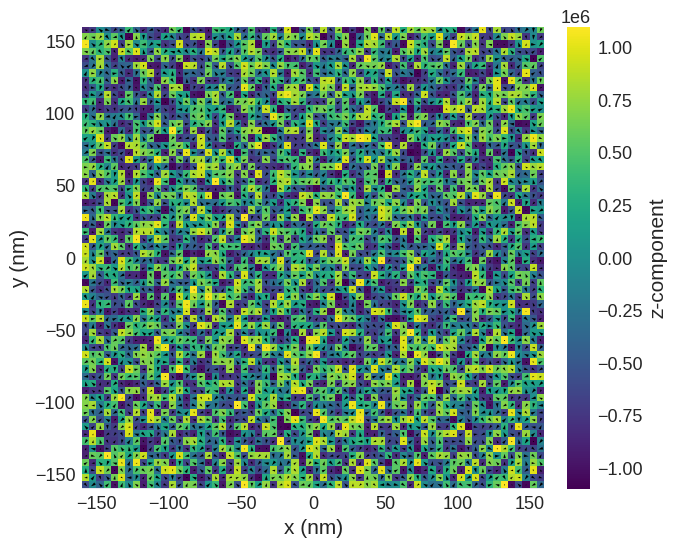

In [1]:
import discretisedfield as df
import micromagneticmodel as mm
import numpy as np
import oommfc as oc
import ubermagutil.units as uu

np.random.seed(1)

region = df.Region(p1=(-160e-9, -160e-9, 0), p2=(160e-9, 160e-9, 20e-9))
mesh = df.Mesh(region=region, cell=(5e-9, 5e-9, 5e-9), bc="xyz")

system = mm.System(name="Box2")

system.energy = (
    mm.Exchange(A=1.6e-11) + mm.DMI(D=4e-3, crystalclass="T") + mm.Zeeman(H=(0, 0, 2e5))
)

Ms = 1.1e6


def m_fun(pos):
    return 2 * np.random.rand(3) - 1


# create system with above geometry and initial magnetisation
system.m = df.Field(mesh, nvdim=3, value=m_fun, norm=Ms)
system.m.sel("z").mpl()

Relax the system and plot its magnetisation.

Running OOMMF (ExeOOMMFRunner)[2023/10/18 12:10]... (70.0 s)


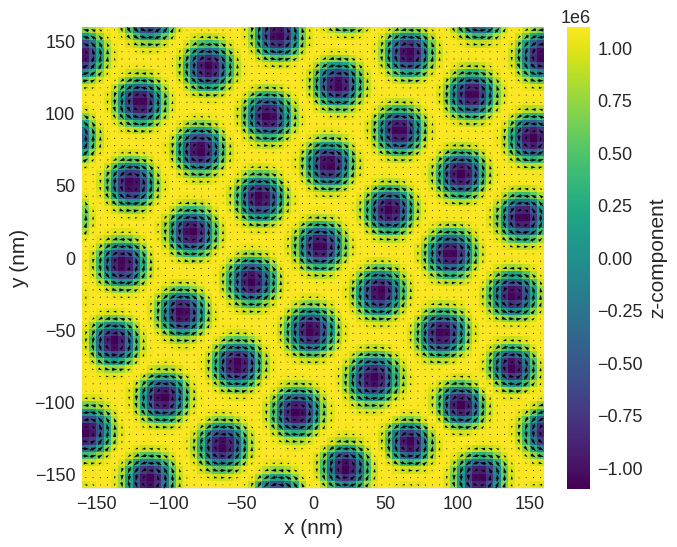

In [2]:
# minimize the energy
md = oc.MinDriver()
md.drive(system)

# Plot relaxed configuration: vectors in z-plane
system.m.sel("z").mpl()

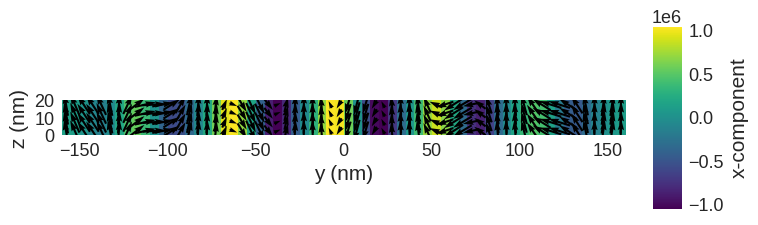

In [3]:
system.m.sel("x").mpl()

Now we have a magnetisation texture we can compute the SANS scattering cross sections.

## Computing SANS Cross-sections

We can use the `mag2exp` package to calculate the cross sections.
The scattering can be calculated with the use of the magnetic interaction vector  ${\bf Q}$ \[[Mühlbauer 2019](https://journals.aps.org/rmp/abstract/10.1103/RevModPhys.91.015004)\] where

\begin{equation}
{\bf Q} = \hat{\bf q} \times \left[ \widetilde{\bf M} \times \hat{\bf q} \right],
\end{equation}
where $\hat{\bf q}$ is the unit scattering vector and $\widetilde{\bf M}$ is the Fourier transform of the magnetisation.

The scattering vector is defined as 
\begin{equation}
{\bf q} = {\bf k}_1 - {\bf k}_0
\end{equation}
where ${\bf k}_0$ and ${\bf k}_1$ are the incident and scattered wavevectors respectively.

From this the magnetic contribution to the cross sections can be calculated as

\begin{equation}
\frac{d\sum}{d\Omega} \sim |{\bf Q} \cdot {\bf \sigma}|^2,
\end{equation}
where ${\bf \sigma}$ is the Pauli vector 
\begin{equation}
{\bf \sigma} = \begin{bmatrix} \sigma_x \\ \sigma_y \\ \sigma_z \end{bmatrix},
\end{equation}
and 
\begin{align}
\sigma_x &= \begin{pmatrix} 0 & 1 \\ 1 & 0 \end{pmatrix}, \\
\sigma_y &= \begin{pmatrix} 0 & -i \\ i & 0 \end{pmatrix}, \\
\sigma_z &= \begin{pmatrix} 1 & 0 \\ 0 & -1 \end{pmatrix}.
\end{align}


For a polarisation in an arbitrary direction the Pauli vector can be rotated.

This takes the form
\begin{equation}
\frac{d\sum}{d\Omega} = \begin{pmatrix}
\frac{d\sum^{++}}{d\Omega} & \frac{d\sum^{-+}}{d\Omega}\\
\frac{d\sum^{+-}}{d\Omega} & \frac{d\sum^{--}}{d\Omega}
\end{pmatrix}
\end{equation}

These then be combined in order to get the half and unpolarised cross sections.

\begin{align}
\frac{d\sum^{+}}{d\Omega} &= \frac{d\sum^{++}}{d\Omega} + \frac{d\sum^{+-}}{d\Omega} \\
\frac{d\sum^{-}}{d\Omega} &= \frac{d\sum^{--}}{d\Omega} + \frac{d\sum^{-+}}{d\Omega} \\
\frac{d\sum}{d\Omega} &= \frac{1}{2} \left( \frac{d\sum^{+}}{d\Omega} + \frac{d\sum^{-}}{d\Omega} \right) \\
\frac{d\sum}{d\Omega} &= \frac{1}{2} \left( \frac{d\sum^{++}}{d\Omega} + \frac{d\sum^{+-}}{d\Omega} + 
\frac{d\sum^{--}}{d\Omega} + \frac{d\sum^{-+}}{d\Omega} \right)
\end{align}

For example the unpolarised cross section calculated with the polarisation along the $z$ direction.

In [4]:
import mag2exp

In [5]:
cross_section = mag2exp.sans.cross_section(
    system.m, method="unpol", polarisation=(0, 0, 1)
)

The `mag2exp.sans.cross_section` function produces a three dimentional cross section in scattering space. A plane of this cross section can then be cut to obtain the relevant scattering plane. For example the `z=0` scattering plane is used here, this is equivalent to the incoming neutron beam being parallel to the $z$ direction.

As the cross section is a `discretisedfield` object the built in plotting functions can be used to view them.

NOTE: The values of the axis in Fourier space are frequency NOT angular frequency so DO NOT include a factor of $2\pi$. i.e. $|{\bf k}| = \frac{1}{\lambda} \neq \frac{2 \pi}{\lambda}$, where $\bf k$ is the wave vector and $\lambda$ is the wavelength.

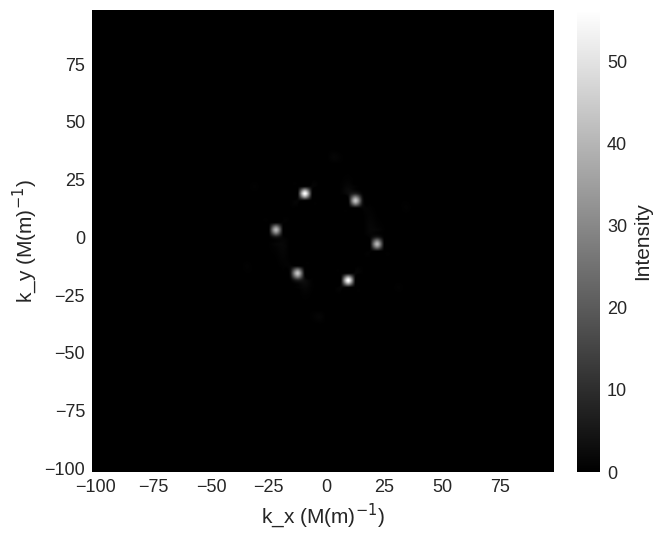

In [6]:
cross_section.sel(k_z=0).mpl.scalar(
    cmap="gray", interpolation="spline16", colorbar_label=r"Intensity"
)

Due to the high intensity of some areas a linear colour map make some features more difficult to see. We can use `matplotlib.color` to change the colour bar to a logarithmic scale. This 
reveals the higher order low intensity diffraction peaks. 

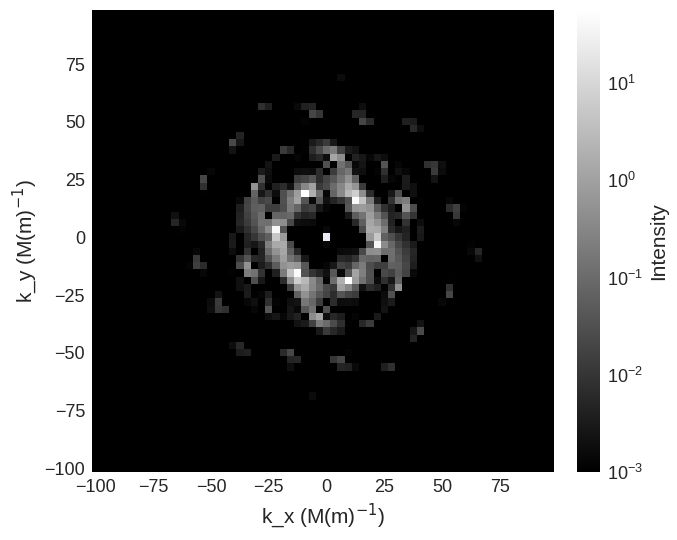

In [7]:
import matplotlib.colors as colors

cross_section.sel(k_z=0).mpl.scalar(
    cmap="gray",
    colorbar_label=r"Intensity",
    norm=colors.LogNorm(vmin=1e-3, vmax=cross_section.real.array.max()),
)

It is also possible to just plot a selected region of the cross section by

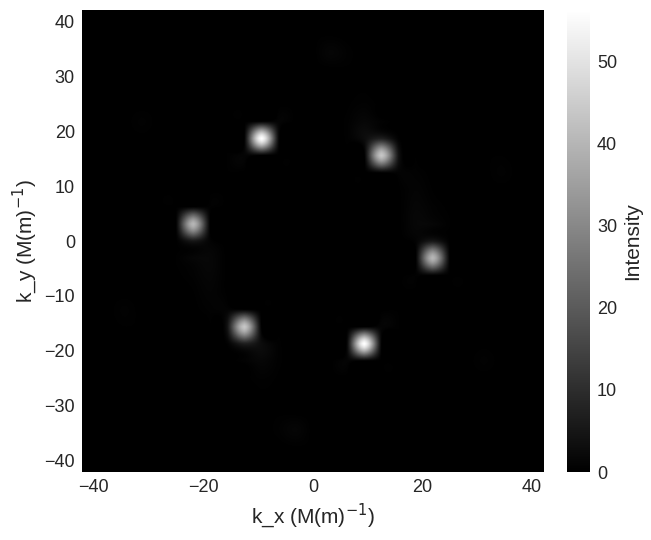

In [8]:
sans_region = df.Region(p1=(-40e6, -40e6), p2=(40e6, 40e6))
cross_section.sel(k_z=0)[sans_region].mpl.scalar(
    cmap="gray", interpolation="spline16", colorbar_label=r"Intensity"
)

For this in the parallel scattering geometry the spin-flip cross sections are

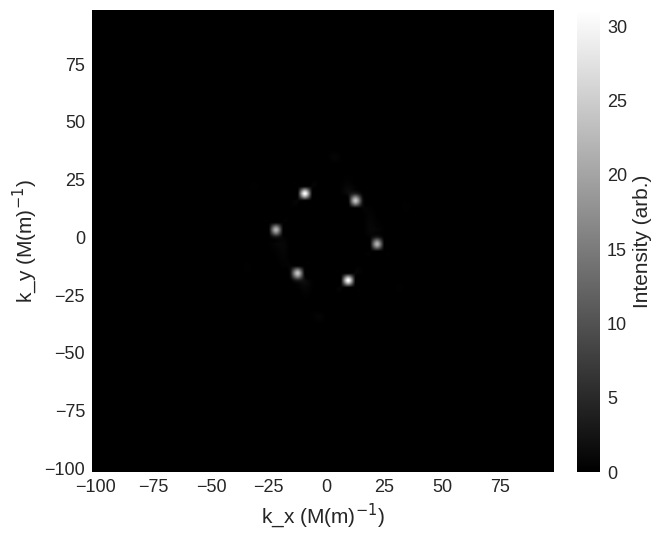

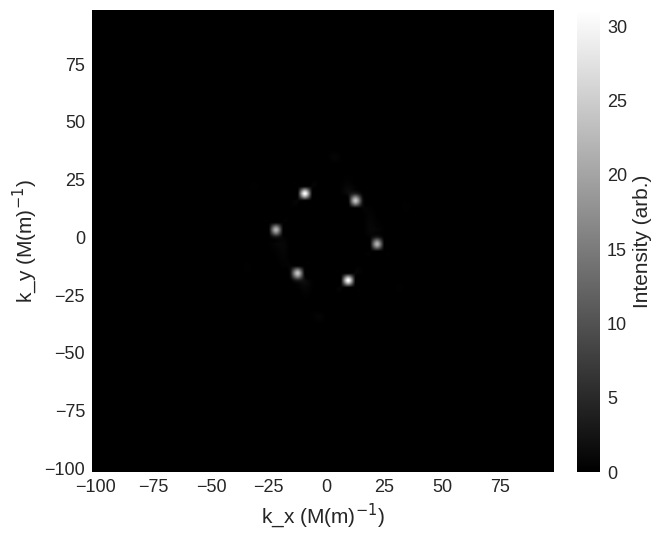

In [9]:
cross_section = mag2exp.sans.cross_section(
    system.m, method="pn", polarisation=(0, 0, 1)
)
cross_section.sel(k_z=0).mpl.scalar(
    cmap="gray", interpolation="spline16", colorbar_label=r"Intensity (arb.)"
)
cross_section = mag2exp.sans.cross_section(
    system.m, method="np", polarisation=(0, 0, 1)
)
cross_section.sel(k_z=0).mpl.scalar(
    cmap="gray", interpolation="spline16", colorbar_label=r"Intensity (arb.)"
)

and non-spin-flip cross sections are

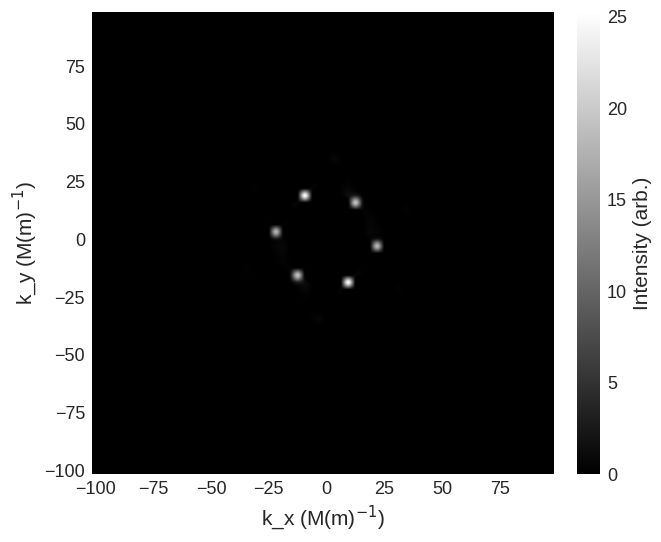

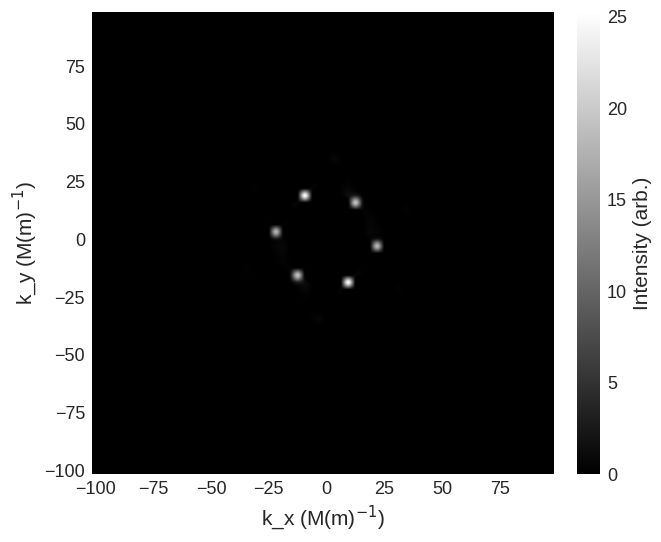

In [10]:
cross_section = mag2exp.sans.cross_section(
    system.m, method="pp", polarisation=(0, 0, 1)
)
cross_section.sel(k_z=0).mpl.scalar(
    cmap="gray", interpolation="spline16", colorbar_label=r"Intensity (arb.)"
)
cross_section = mag2exp.sans.cross_section(
    system.m, method="nn", polarisation=(0, 0, 1)
)
cross_section.sel(k_z=0).mpl.scalar(
    cmap="gray", interpolation="spline16", colorbar_label=r"Intensity (arb.)"
)

We can also look at the scattering geometry where the beam and polarisation are no longer parallel.

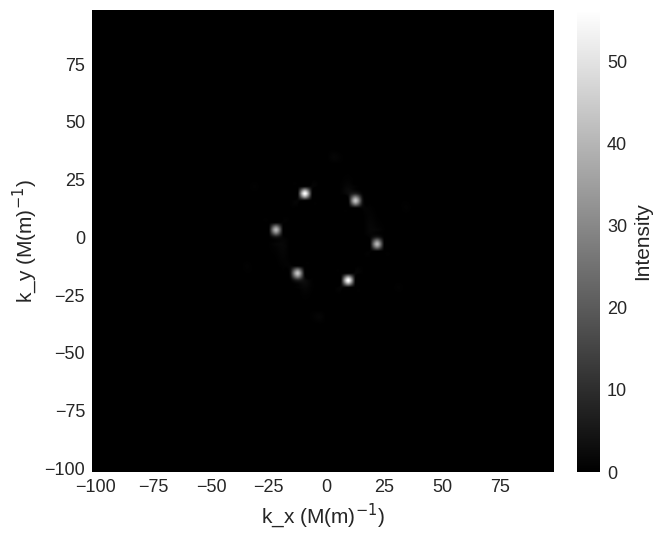

In [11]:
cross_section = mag2exp.sans.cross_section(
    system.m, method="unpol", polarisation=(1, 0, 0)
)
cross_section.sel(k_z=0).mpl.scalar(
    cmap="gray", interpolation="spline16", colorbar_label=r"Intensity"
)

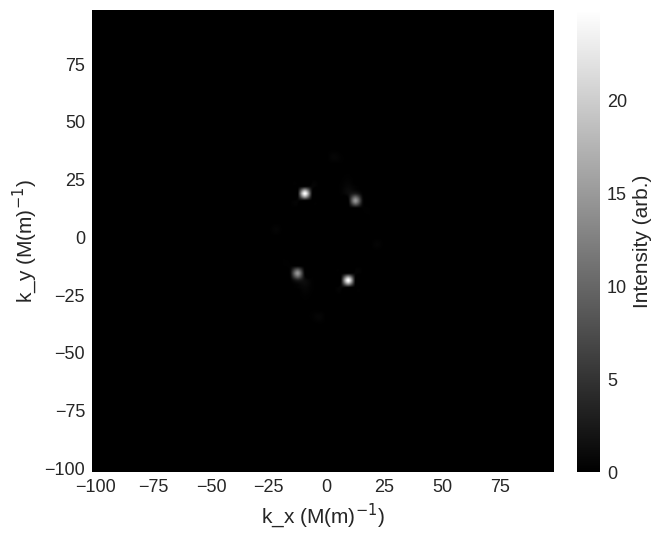

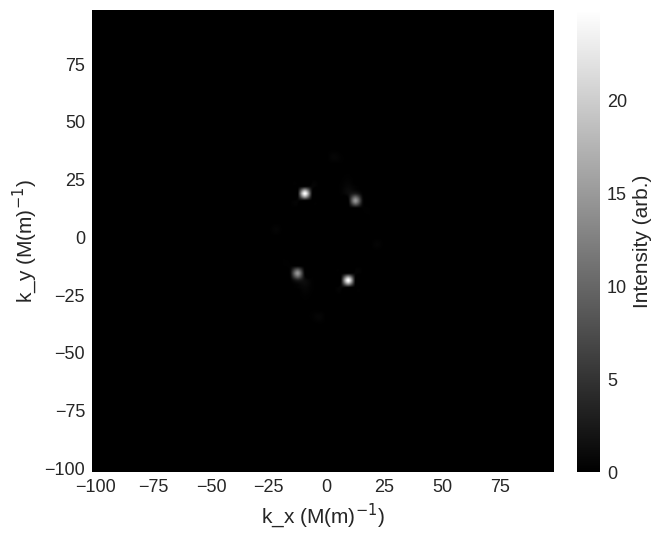

In [12]:
cross_section = mag2exp.sans.cross_section(
    system.m, method="pp", polarisation=(1, 0, 0)
)
cross_section.sel(k_z=0).mpl.scalar(
    cmap="gray", interpolation="spline16", colorbar_label=r"Intensity (arb.)"
)
cross_section = mag2exp.sans.cross_section(
    system.m, method="nn", polarisation=(1, 0, 0)
)
cross_section.sel(k_z=0).mpl.scalar(
    cmap="gray", interpolation="spline16", colorbar_label=r"Intensity (arb.)"
)

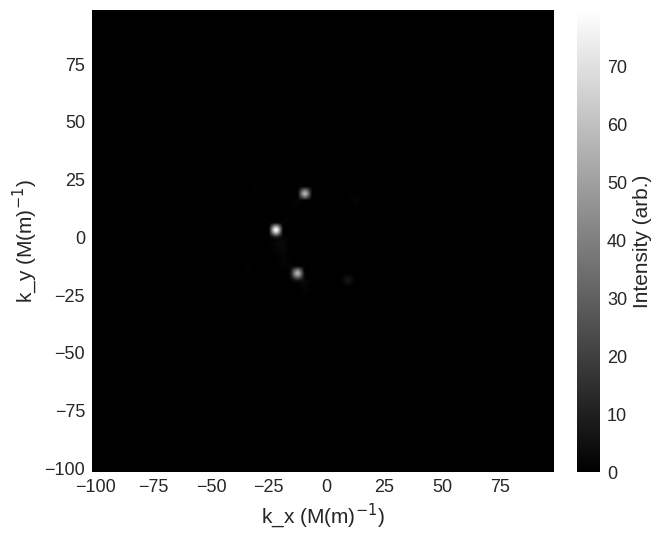

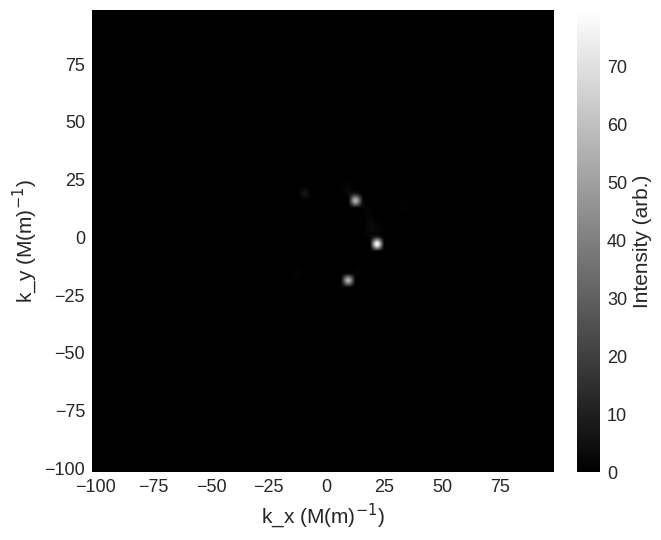

In [13]:
cross_section = mag2exp.sans.cross_section(
    system.m, method="pn", polarisation=(1, 0, 0)
)
cross_section.sel(k_z=0).mpl.scalar(
    cmap="gray", interpolation="spline16", colorbar_label=r"Intensity (arb.)"
)
cross_section = mag2exp.sans.cross_section(
    system.m, method="np", polarisation=(1, 0, 0)
)
cross_section.sel(k_z=0).mpl.scalar(
    cmap="gray", interpolation="spline16", colorbar_label=r"Intensity (arb.)"
)

It is possible to examine the chiral function $-2i\chi$, which gives an indication of the asymmetry of the scattering.

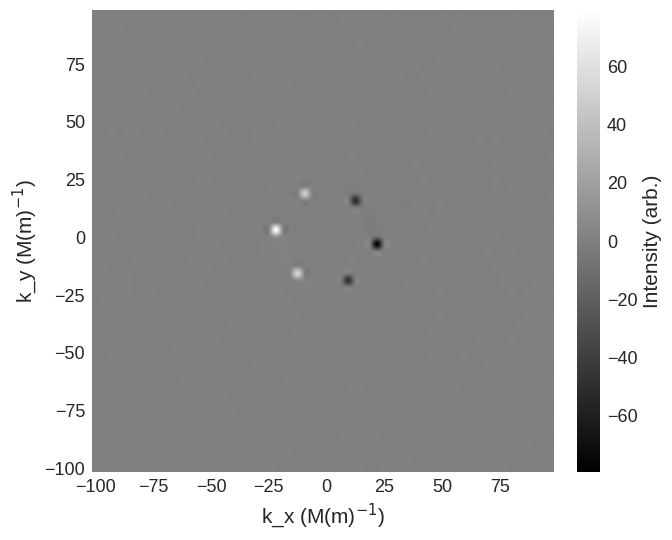

In [14]:
chiral = mag2exp.sans.chiral_function(system.m, polarisation=(1, 0, 0))
chiral.sel(k_z=0).mpl.scalar(
    cmap="gray", interpolation="spline16", colorbar_label=r"Intensity (arb.)"
)